In [60]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
)
from sklearn.model_selection import train_test_split

# Load Unlabeled Sequences
print("\n🔍 Loading unlabeled sequences...")
unlabeled_file_path = "processed_unlabelled_sequences.csv"
df_unlabeled = pd.read_csv(unlabeled_file_path)

# Ensure there's no missing data
if "sequence" not in df_unlabeled.columns:
    raise ValueError("❌ The CSV must contain a 'sequence' column!")

df_unlabeled = df_unlabeled.dropna(subset=["sequence"])
print(f"✅ Loaded {len(df_unlabeled)} unlabeled sequences.")

# **SPLIT INTO TRAIN AND VALIDATION SET**
train_df, valid_df = train_test_split(df_unlabeled, test_size=0.2, random_state=42)
print(f"\n📊 Splitting dataset: {len(train_df)} training sequences, {len(valid_df)} validation sequences.")

# Convert into Hugging Face Dataset format
dataset_train = Dataset.from_pandas(train_df)
dataset_valid = Dataset.from_pandas(valid_df)

# Load Tokenizer
checkpoint = "facebook/esm2_t6_8M_UR50D"
print(f"\n🚀 Loading tokenizer from: {checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize sequences
def tokenize_function(examples):
    return tokenizer(examples["sequence"], truncation=True, padding="max_length", max_length=256)

print("\n🔄 Tokenizing datasets...")
tokenized_train = dataset_train.map(tokenize_function, batched=True)
tokenized_valid = dataset_valid.map(tokenize_function, batched=True)
print(f"✅ Tokenization complete. Sample tokenized input: {tokenized_train[0]['input_ids'][:10]}")

# Set up MLM Data Collator (masks 15% of tokens)
mlm_probability = 0.15
print(f"\n🎭 Creating MLM data collator (masking probability: {mlm_probability})")
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=mlm_probability
)

# Load Model for MLM
print(f"\n🚀 Loading ESM model for MLM from: {checkpoint}")
model_mlm = AutoModelForMaskedLM.from_pretrained(checkpoint)
print("✅ Model loaded successfully.")

# Define Training Arguments
print("\n🛠️ Configuring training arguments...")
training_args = TrainingArguments(
    output_dir="./esm_mlm_pretraining",
    evaluation_strategy="epoch",  # Enable evaluation every epoch
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=10,
    report_to="none",
)
print(f"✅ Training Arguments Configured: {training_args}")

# Initialize Trainer with Validation Data
print("\n🚀 Initializing MLM Trainer (with validation)...")
trainer = Trainer(
    model=model_mlm,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,  # ADDING VALIDATION DATA HERE ✅
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print("✅ Trainer initialized successfully.")

# Start Pre-Training
print("\n🚀 Starting MLM Pre-training...")
trainer.train()
print("\n✅ Pre-training complete!")

# Save the Pre-Trained Model
print("\n💾 Saving pre-trained model...")
model_mlm.save_pretrained("./esm_mlm_pretrained")
tokenizer.save_pretrained("./esm_mlm_pretrained")
print("✅ Pre-trained model saved successfully.")



🔍 Loading unlabeled sequences...
✅ Loaded 31917 unlabeled sequences.

📊 Splitting dataset: 25533 training sequences, 6384 validation sequences.

🚀 Loading tokenizer from: facebook/esm2_t6_8M_UR50D

🔄 Tokenizing datasets...


Map: 100%|██████████| 6384/6384 [00:06<00:00, 1036.99 examples/s]
/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_10634/1800347673.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Tokenization complete. Sample tokenized input: [0, 16, 7, 16, 4, 7, 16, 8, 6, 5]

🎭 Creating MLM data collator (masking probability: 0.15)

🚀 Loading ESM model for MLM from: facebook/esm2_t6_8M_UR50D
✅ Model loaded successfully.

🛠️ Configuring training arguments...
✅ Training Arguments Configured: TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_para

Epoch,Training Loss,Validation Loss
1,0.094400,0.078967


KeyboardInterrupt: 

In [43]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

# Load the saved model and tokenizer
model_checkpoint = "./esm_mlm_pretrained"
print(f"🚀 Loading trained MLM model from: {model_checkpoint}")

model_mlm = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print("✅ Model and tokenizer loaded successfully.")

# Run evaluation on the validation dataset
print("\n📊 Evaluating MLM performance on validation dataset...")
eval_results = trainer.evaluate()

# Print evaluation results
print("\n🔍 MLM Validation Evaluation Metrics:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

🚀 Loading trained MLM model from: ./esm_mlm_pretrained
✅ Model and tokenizer loaded successfully.

📊 Evaluating MLM performance on validation dataset...



🔍 MLM Validation Evaluation Metrics:
eval_loss: 0.0649
eval_runtime: 30.3150
eval_samples_per_second: 210.5890
eval_steps_per_second: 26.3240
epoch: 1.0000


In [48]:
import torch

# Example masked sequence
sequence = pd.read_csv(unlabeled_file_path)['sequence'].values[0]

masked_sequence = sequence[:10] + '<mask>' +  sequence[11:]

inputs = tokenizer(masked_sequence, return_tensors="pt")

# Move tensors to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model_mlm.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate predictions
with torch.no_grad():
    outputs = model_mlm(**inputs)
    predictions = outputs.logits.argmax(dim=-1)

# Convert predicted token IDs back to words
predicted_tokens = tokenizer.convert_ids_to_tokens(predictions[0].tolist())

# Print original and predicted sequence
print(sequence)

print("\n🔍 Masked Input Sequence:")
print(masked_sequence)

print("\n🧠 Predicted Sequence:")
print(tokenizer.decode(predictions[0], skip_special_tokens=False))


QVQLVQSGAEVKKPGASVKVSCKVSGYSFTDHSIHWVRQAPGKGLEWMGGINPYTGDTIYAQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCARDGYSSRYYYYGMDVWGQGTTVTVSS:DIQMTQSPSSVSASVGDRVTITCRASQGIGRDLAWYQQKPGKAPKLLIYEASTLKPGVPSRFSGSGSGTDFTLTISSLQPEDFANYYCHQYATYPWTFGGGTKVEIK

🔍 Masked Input Sequence:
QVQLVQSGAE<mask>KKPGASVKVSCKVSGYSFTDHSIHWVRQAPGKGLEWMGGINPYTGDTIYAQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCARDGYSSRYYYYGMDVWGQGTTVTVSS:DIQMTQSPSSVSASVGDRVTITCRASQGIGRDLAWYQQKPGKAPKLLIYEASTLKPGVPSRFSGSGSGTDFTLTISSLQPEDFANYYCHQYATYPWTFGGGTKVEIK

🧠 Predicted Sequence:
<cls> Q V Q L V Q S G A E V K K P G A S V K V S C K V S G Y S F T D H S I H W V R Q A P G K G L E W M G G I N P Y T G D T I Y A Q K F Q G R V T M T E D T S T D T A Y M E L S S L K S E D T A V Y Y C A R D G Y S S S Y Y Y Y G M D V W G Q G T T V T V S S I D I Q M T Q S P S S V S A S V G D R V T I T C R A S Q G I G R D L A W Y Q Q K P G K A P K L L I Y E A S T L K P G V P S R F S G S G S G T D F T L T I S S L Q P E D F A N Y Y C H Q Y A T Y P W T F G G G T K V E I K <eos>


In [56]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
)
from datasets import Dataset
from peft import LoraConfig, inject_adapter_in_model
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split

# **🔍 Load the labeled dataset (binding affinities)**
print("\n🔍 Loading labeled dataset for fine-tuning...")
file_path = "processed_sequences.csv"  # Replace with actual file path

df = pd.read_csv(file_path)


if "sequence" not in df.columns or "binding_affinity" not in df.columns:
    raise ValueError("❌ CSV must contain 'sequence' and 'binding_affinity' columns.")


df["binding_affinity"] = df["binding_affinity"].astype(float)

# Define the number of bins (adjust depending on dataset size)
num_bins = 10  # More bins → finer stratification

# Create bins based on binding affinity distribution
df["affinity_bin"] = pd.qcut(df["binding_affinity"], num_bins, labels=False, duplicates="drop")

# Stratified train-test split
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["affinity_bin"], random_state=42)

# Drop the auxiliary bin column
train_df = train_df.drop(columns=["affinity_bin"])
valid_df = valid_df.drop(columns=["affinity_bin"])

print(f"✅ Stratified Dataset Split: {len(train_df)} training, {len(valid_df)} validation samples.")

# 🚀 Load Pre-Trained Model for Sequence Classification
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# 🔄 Tokenization Function
def tokenize_function(examples):
    encoding = tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=256)
    encoding["labels"] = examples["binding_affinity"]  # Ensure labels are attached
    return encoding

# 🔄 Tokenizing Training and Validation Data
print("\n🔄 Tokenizing data...")
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
valid_dataset = Dataset.from_pandas(valid_df).map(tokenize_function, batched=True)
print("✅ Tokenization complete.")

# 🚀 Debug: Check a sample output
print("🔍 Sample training data:", train_dataset[0])

# **🚀 Load Pre-Trained Model for Sequence Classification**
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# **🛠️ Inject LoRA Adaptation (Optional)**
peft_config = LoraConfig(r=8, lora_alpha=2, bias="all", target_modules=["query", "key", "value", "dense"])
model = inject_adapter_in_model(peft_config, model)
print("✅ LoRA adapter injected.")

# **🛠️ Define Training Arguments**
training_args = TrainingArguments(
    output_dir="./esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_steps=10,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
)

# **🚀 Initialize Trainer**
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if no improvement for 3 epochs
)

# **🚀 Start Fine-Tuning**
print("\n🚀 Fine-tuning model on binding affinity data...")
trainer.train()
print("\n✅ Fine-tuning complete!")

# **💾 Save the Model**
print("\n💾 Saving fine-tuned model...")
model.save_pretrained("./esm_finetuned")
tokenizer.save_pretrained("./esm_finetuned")
print("✅ Fine-tuned model saved successfully.")

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Loading labeled dataset for fine-tuning...
✅ Stratified Dataset Split: 113 training, 29 validation samples.

🚀 Loading pre-trained model for regression...

🔄 Tokenizing data...


Map: 100%|██████████| 29/29 [00:00<00:00, 845.83 examples/s]
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_10634/1009672534.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Tokenization complete.
🔍 Sample training data: {'sequence': 'QVQLVQSGAEVKKPGASVKVSCKVSGYSFTDHSIHWVRQAPGKGLEWMGGINPYTGDTIYAQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCARDGYSYGYLSGMDVWGQGTTVTVSS:DIQMTQSPSSVSASVGDRVTITCRASQPISSYLAWYQQKPGKAPKLLIYEASKLQSGVPSRFSGSGSGTDFTLTISSLQPEDFANYYCHQYATYPWTFGGGTKVEIK', 'binding_affinity': 0.1654655837337344, '__index_level_0__': 42, 'input_ids': [0, 16, 7, 16, 4, 7, 16, 8, 6, 5, 9, 7, 15, 15, 14, 6, 5, 8, 7, 15, 7, 8, 23, 15, 7, 8, 6, 19, 8, 18, 11, 13, 21, 8, 12, 21, 22, 7, 10, 16, 5, 14, 6, 15, 6, 4, 9, 22, 20, 6, 6, 12, 17, 14, 19, 11, 6, 13, 11, 12, 19, 5, 16, 15, 18, 16, 6, 10, 7, 11, 20, 11, 9, 13, 11, 8, 11, 13, 11, 5, 19, 20, 9, 4, 8, 8, 4, 15, 8, 9, 13, 11, 5, 7, 19, 19, 23, 5, 10, 13, 6, 19, 8, 19, 6, 19, 4, 8, 6, 20, 13, 7, 22, 6, 16, 6, 11, 11, 7, 11, 7, 8, 8, 3, 13, 12, 16, 20, 11, 16, 8, 14, 8, 8, 7, 8, 5, 8, 7, 6, 13, 10, 7, 11, 12, 11, 23, 10, 5, 8, 16, 14, 12, 8, 8, 19, 4, 5, 22, 19, 16, 16, 15, 14, 6, 15, 5, 14, 15, 4, 4, 12, 19, 9, 5, 8, 15,

Epoch,Training Loss,Validation Loss
1,0.057800,0.063548
2,0.049200,0.061011
3,0.051500,0.058160
4,0.038500,0.054398
5,0.046300,0.053555
6,0.028600,0.049329
7,0.036400,0.056356
8,0.033300,0.048275
9,0.040200,0.043494
10,0.042000,0.037264



✅ Fine-tuning complete!

💾 Saving fine-tuned model...
✅ Fine-tuned model saved successfully.


      epoch  total_flos    loss  eval_loss
0  0.344828         NaN  0.1213        NaN
1  0.689655         NaN  0.0578        NaN
2  1.000000         NaN     NaN   0.063548
3  1.034483         NaN  0.0564        NaN
4  1.379310         NaN  0.0384        NaN


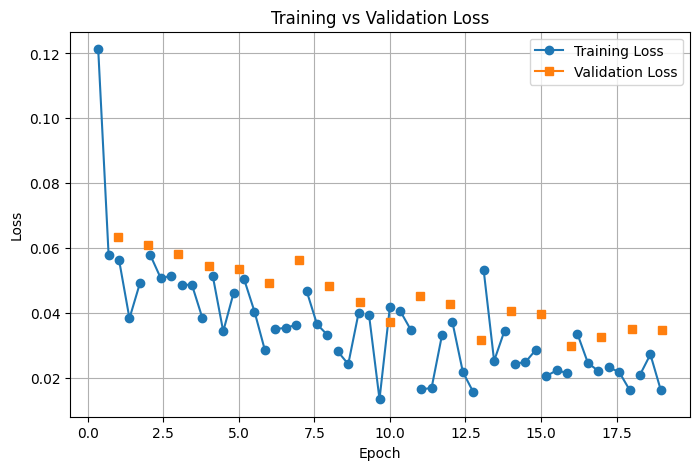

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract training logs
log_history = trainer.state.log_history

# Convert to DataFrame
df_logs = pd.DataFrame(log_history)[["epoch", "total_flos", "loss", "eval_loss"]]
df_logs = df_logs.dropna(how="all")

# Display available keys
print(df_logs.head())

plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["loss"], label="Training Loss", marker="o")
plt.plot(df_logs["epoch"], df_logs["eval_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [58]:
predictions = trainer.predict(valid_dataset)
preds = predictions.predictions.flatten()  # Flatten if single-output regression
labels = predictions.label_ids

# Convert to DataFrame
df_results = pd.DataFrame({"Actual": labels, "Predicted": preds})

# Display first few rows
print(df_results.head())

     Actual  Predicted
0  0.664207   0.688724
1  0.625342   0.652160
2  0.196822   0.207266
3  0.302664   0.177946
4  0.075440   0.186519


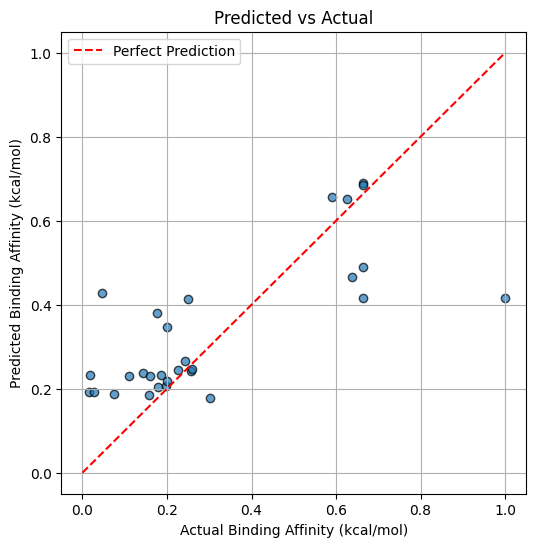

In [59]:
plt.figure(figsize=(6, 6))
plt.scatter(labels, preds, alpha=0.7, edgecolors="k")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Prediction")  # Identity line
plt.xlabel("Actual Binding Affinity (kcal/mol)")
plt.ylabel("Predicted Binding Affinity (kcal/mol)")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid()
plt.show()

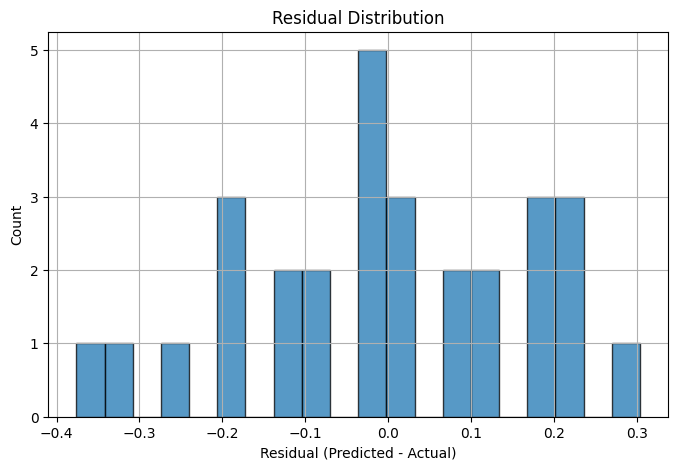

In [21]:
residuals = preds - labels

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, alpha=0.75, edgecolor="black")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid()
plt.show()

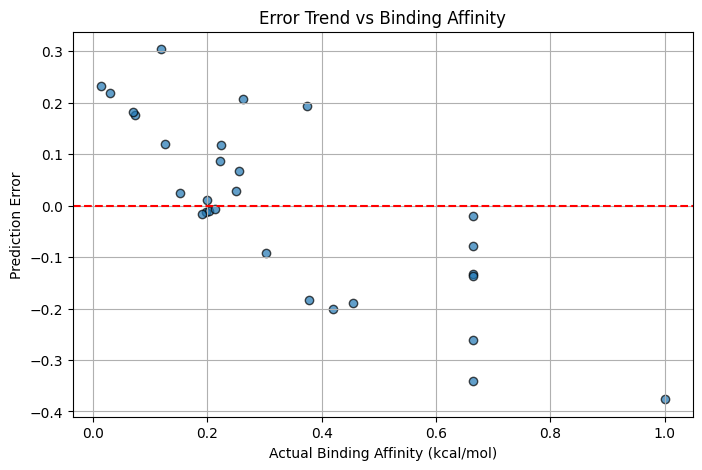

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(labels, residuals, alpha=0.7, edgecolors="k")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Actual Binding Affinity (kcal/mol)")
plt.ylabel("Prediction Error")
plt.title("Error Trend vs Binding Affinity")
plt.grid()
plt.show()

In [41]:
df = pd.read_csv(unlabeled_file_path)

max([len(x) for x in df['sequence']])

245